# qGANs for Loading Random Distributions 

$$|g_{\theta}\rangle = \sum_{j=0}^{2^{n}-1} \sqrt{p_{\theta}^{j}} |j\rangle$$ 

, where $p_{\theta}^{j}$ describes the occurance probability of the basis states $|j\rangle$. The goal of the training is to generate a distribution $|g_{\theta}\rangle$ that emulates the distribution of the underlying training data $X = \{x^{0}, \dots, x^{k-1}\}$

## Training dataset 

The training dataset is given by a 2D multivariate normal distribution for this notebook. 

$$|g_{tr}\rangle = \sum_{j=0}^{k-1} \sqrt{p_{j}} | x_{j}\rangle$$

, where $|x_{j}\rangle$ represents the data items in the training data set and $p_{j}$ is its sampling probability.

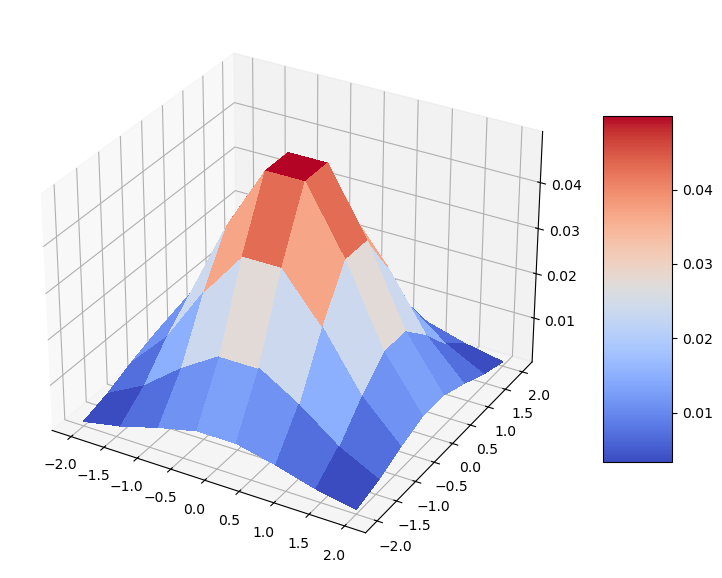

In [1]:
import torch 
from qiskit_algorithms.utils import algorithm_globals
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt 
from matplotlib import cm

algorithm_globals.random_seed = 123456
_ = torch.manual_seed(123456)

num_dim = 2
num_discrete_values = 8
num_qubits = num_dim * int(np.log2(num_discrete_values))

# Preparing discrete distribution 
coords = np.linspace(-2, 2, num_discrete_values)
rv = multivariate_normal(mean=[0.0, 0.0], cov=[[1,0], [0,1]], seed=algorithm_globals.random_seed)
grid_elements = np.transpose([np.tile(coords, len(coords)), np.repeat(coords, len(coords))])
prob_data = rv.pdf(grid_elements)
prob_data = prob_data / np.sum(prob_data) # Normalization

# Visualization
mesh_x, mesh_y = np.meshgrid(coords, coords)
grid_shape = (num_discrete_values, num_discrete_values)

fig, ax = plt.subplots(figsize=(9,9), subplot_kw={"projection": "3d"})
prob_grid = np.reshape(prob_data, grid_shape)
surf = ax.plot_surface(mesh_x, mesh_y, prob_grid, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Neural Networks

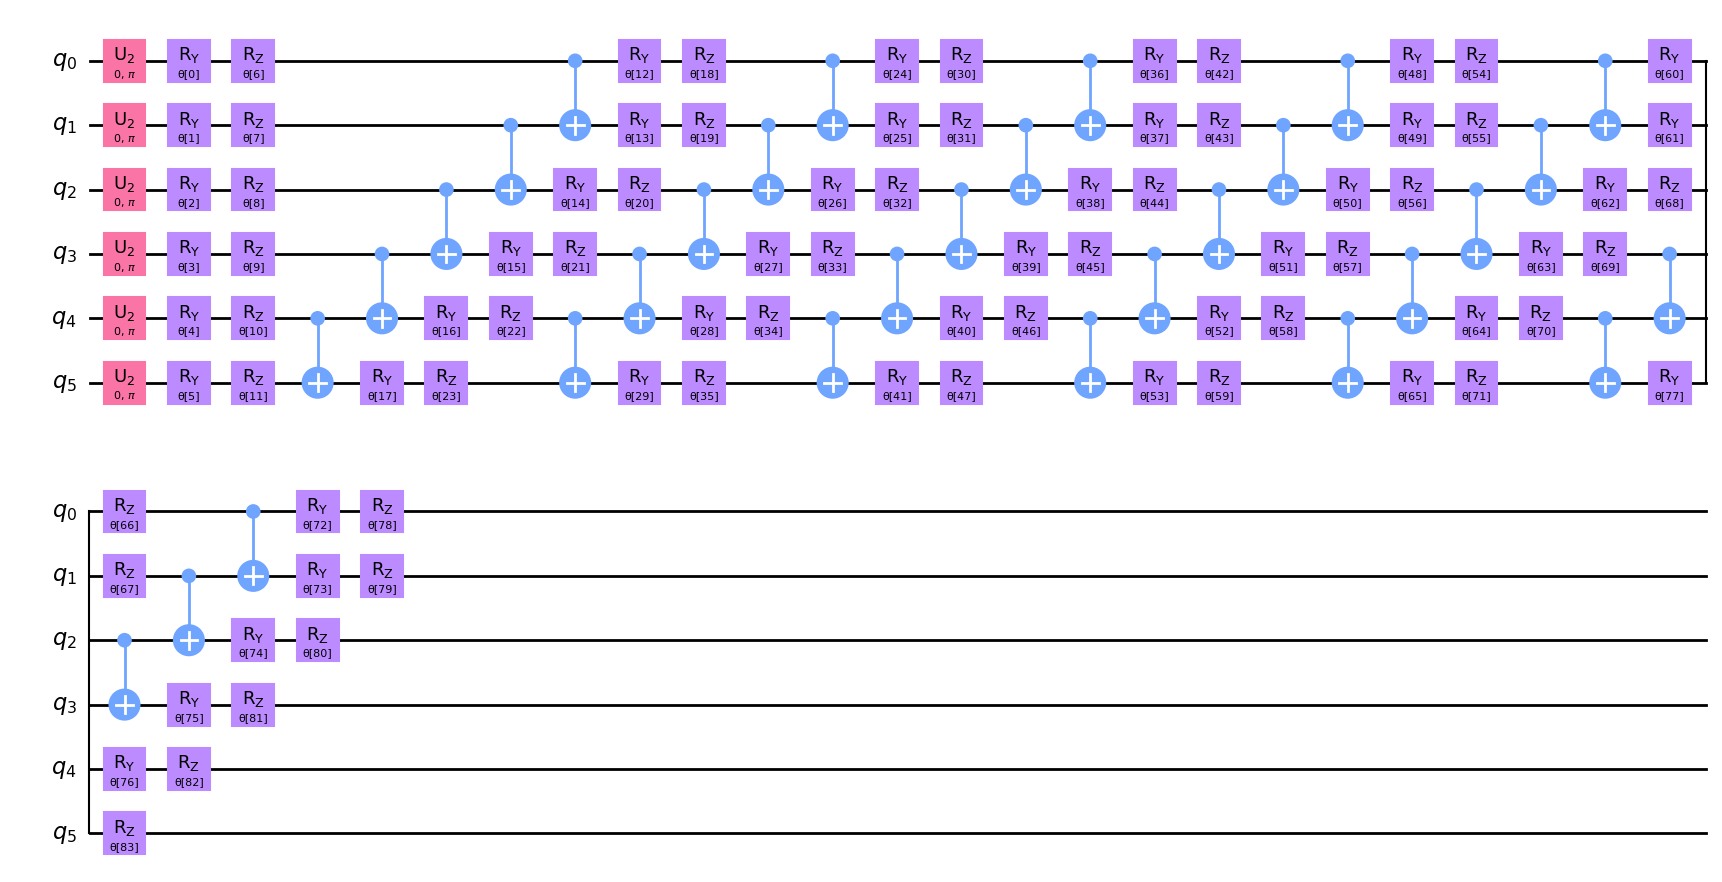

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2

qc = QuantumCircuit(num_qubits)
qc.h(qc.qubits)

ansatz = EfficientSU2(num_qubits, reps=6)
qc.compose(ansatz, inplace=True)

qc.decompose().draw(output='mpl', style='clifford')

In [3]:
qc.num_parameters

84

## Quantum generator

In [4]:
from qiskit.primitives import StatevectorSampler as Sampler 
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN

sampler = Sampler()

# Creating quantum generator from a parameterized quantum circiut: 
def create_generator() -> TorchConnector:
    qnn = SamplerQNN(circuit=qc, sampler=sampler, input_params=[], weight_params=qc.parameters, sparse=False,)
    
    initial_weights = algorithm_globals.random.random(qc.num_parameters)
    return TorchConnector(qnn, initial_weights)

## Classical discriminator 

In [5]:
from torch import nn

class Discriminator(nn.Module):
    def __init__(self, input_size): 
        super(Discriminator, self).__init__()
        
        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

In [6]:
generator = create_generator()
discriminator = Discriminator(num_dim)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


# Training Loop

The loss function is defined as follows: 

$$L(\theta) = \sum_{j} p_{j}(\theta)[y_{j}\log(x_{j}) + (1-y_{j})\log(1-x_{j})]$$

, where $x_{j}$ is a data sample and $y_{j}$ is the corresponding label. This is known as a binary cross entropy loss function.

In [7]:
from torch.optim import Adam

def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

# Optimization scheme
lr = 0.01 # learning rate
b1 = 0.7 # first momentum parameter 
b2 = 0.999 # second momentum parameter

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.05)
discriminator_optimizer = Adam(discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.05)

In [8]:
# Visualization 
from IPython.display import clear_output

def plot_training_progress():
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy")
    ax2.plot(entropy_values)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()

    plt.show()

# Model Training

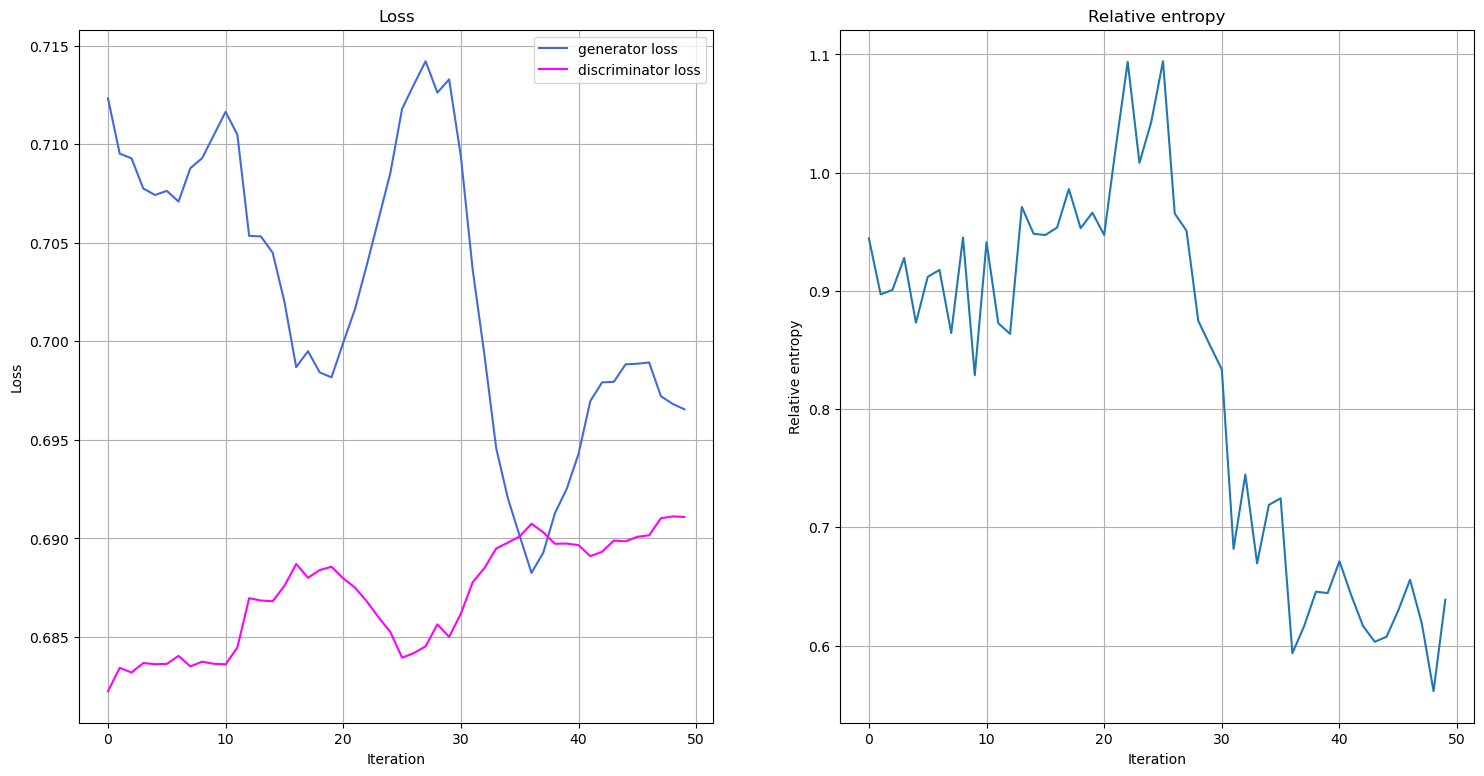

Fit in 51.99 secs.


In [10]:
import time 
from scipy.stats import multivariate_normal, entropy

n_epochs = 50

num_qnn_outputs = num_discrete_values ** num_dim

generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

start = time.time()
for epoch in range(n_epochs):
    valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)
    fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)
    
    # configure input 
    real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)
    
    # configure samples 
    samples = torch.tensor(grid_elements, dtype=torch.float)
    disc_value = discriminator(samples)
    
    # generating data
    gen_dist = generator(torch.tensor([])).reshape(-1, 1)
    
    # training generator
    generator_optimizer.zero_grad()
    generator_loss = adversarial_loss(disc_value, valid, gen_dist)
    
    # storing data
    generator_loss_values.append(generator_loss.detach().item())

    generator_loss.backward(retain_graph=True)
    generator_optimizer.step()
    
    # training discriminator
    discriminator_optimizer.zero_grad()
    
    real_loss = adversarial_loss(disc_value, valid, real_dist)
    fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach())
    discriminator_loss = (real_loss + fake_loss) / 2
    
    # storing data 
    discriminator_loss_values.append(discriminator_loss.detach().item())
    
    discriminator_loss.backward()
    discriminator_optimizer.step()
    
    entropy_value = entropy(gen_dist.detach().squeeze().numpy(), prob_data)
    entropy_values.append(entropy_value)
    
    plot_training_progress()
    
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} secs.")

## Cumulative Density Functions (CDF)

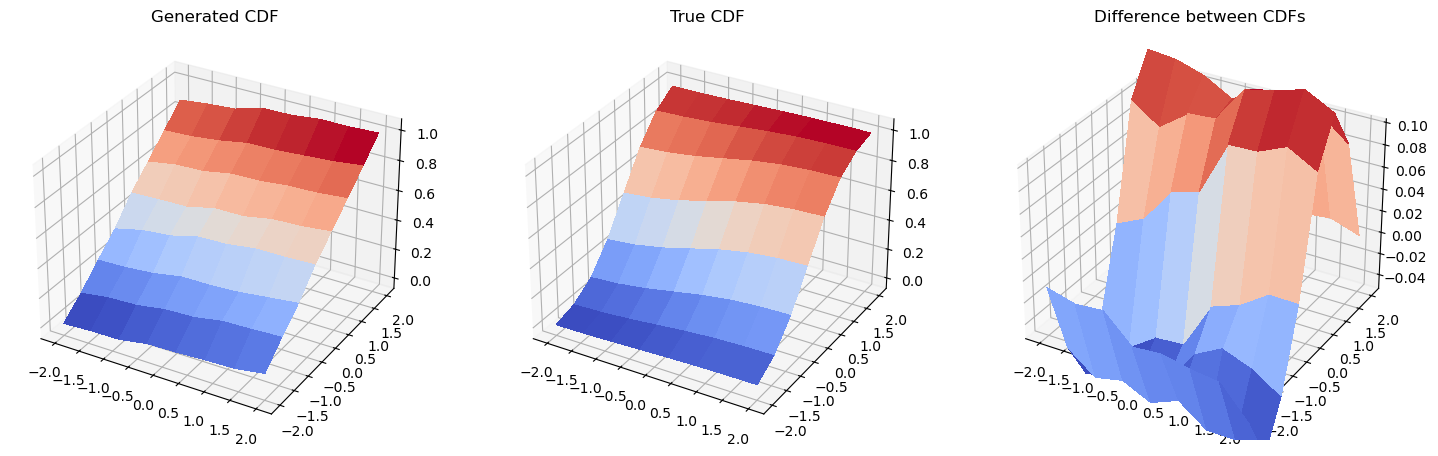

In [12]:
with torch.no_grad():
    generated_probabilities = generator().numpy()
    
fig = plt.figure(figsize=(18, 9))

# Generated CDF
gen_prob_grid = np.reshape(np.cumsum(generated_probabilities), grid_shape)

ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax1.set_title("Generated CDF")
ax1.plot_surface(mesh_x, mesh_y, gen_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax1.set_zlim(-0.05, 1.05)

# Real CDF
real_prob_grid = np.reshape(np.cumsum(prob_data), grid_shape)

ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax2.set_title("True CDF")
ax2.plot_surface(mesh_x, mesh_y, real_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax2.set_zlim(-0.05, 1.05)

# Difference
ax3 = fig.add_subplot(1, 3, 3, projection="3d")
ax3.set_title("Difference between CDFs")
ax3.plot_surface(
    mesh_x, mesh_y, real_prob_grid - gen_prob_grid, linewidth=2, antialiased=False, cmap=cm.coolwarm
)
ax3.set_zlim(-0.05, 0.1)
plt.show()